<a href="https://colab.research.google.com/github/EmilyWarnerSoderholm/ihMT_MRF/blob/main/Emily%2C_ihMT_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

directory = '/content/drive/My Drive/group_project/MT_training_E/'  # we define the directory of the data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Defining network architecture
class ihMT_nn(nn.Module):
    def __init__(self):
        super(ihMT_nn, self).__init__()
        # First layer takes signal as input
        self.input_layer = nn.Linear(1200,300)
        # Define hidden layer block
        self.hidden_layer = nn.Linear(300,300)
        self.output_layer = nn.Linear(300,3)

    def forward(self, x):
        x = x.view(-1, 1200)
        x = torch.tanh(self.input_layer(x))
        x = torch.tanh(self.hidden_layer(x))
        x = torch.sigmoid(self.output_layer(x))

        return x

In [8]:
# Define testing routine
def test():
    # Set the model to evaluate mode.
    preds = np.array([[0, 0, 0]])
    noisy_preds = np.array([[0, 0, 0]])
    net.eval()
    noisy_net.eval()
    for signal, _ in test_loader:
        mu, sigma = 0, 0.01 * max_signals
        noise = torch.from_numpy(np.random.normal(mu, sigma, (signal.shape[0], signal.shape[1])))
        noisy_signal = signal + noise
        noisy_signal = noisy_signal.type(torch.float32)

        signal = signal.to(device)
        noisy_signal = noisy_signal.to(device)
        with torch.no_grad():
            output = net(signal).cpu().numpy()
            noisy_output = noisy_net(noisy_signal).cpu().numpy()
        preds = np.concatenate((preds, output), axis=0)
        noisy_preds = np.concatenate((noisy_preds, noisy_output), axis=0)

    return np.delete(preds, (0), axis=0), np.delete(noisy_preds, (0), axis=0)
    

In [11]:
# Now to setup the data loaders
random.seed(42)
net = torch.load(directory + 'MT_nn_dict_one.pt')
net = net.to(device)
noisy_net = torch.load(directory + 'MT_nn_noisy_dict_one.pt')
noisy_net = noisy_net.to(device)

# Load data
dataMss = sio.loadmat(directory + 'Mss_AllSigs_TEST.mat')
dataVP = sio.loadmat(directory + 'VP_AllSigs_TEST.mat')
signal_data = dataMss['Mss_AllSigs']
n_samples, n_t = signal_data.shape
label_data = dataVP['VP_AllSigs'][:,[1, 4, 6]]

# Normalise data and labels
signals = np.absolute(signal_data)
labels = label_data

signal_means = np.mean(signals, axis=1)
signals = signals / signal_means[:, None]
max_signals = np.max(signals)
max_labels = np.array([0.2, 4, 0.008])
labels = labels / max_labels[None,:]

test_signals = torch.from_numpy(signals).type(torch.float32)
test_labels = torch.from_numpy(labels).type(torch.float32)

test_dataset = torch.utils.data.TensorDataset(test_signals, test_labels)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False)

Testing network...
[0.         0.02222222 0.04444444 0.06666667 0.08888889 0.11111111
 0.13333333 0.15555556 0.17777778 0.2       ]


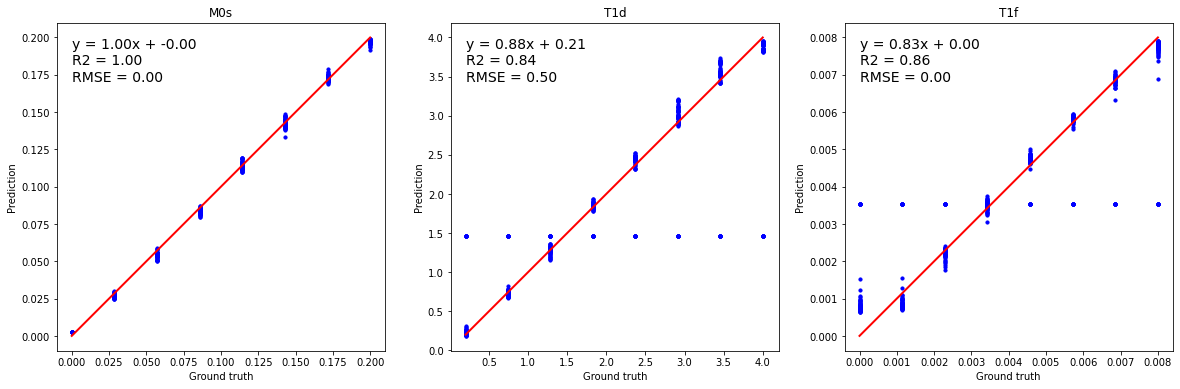

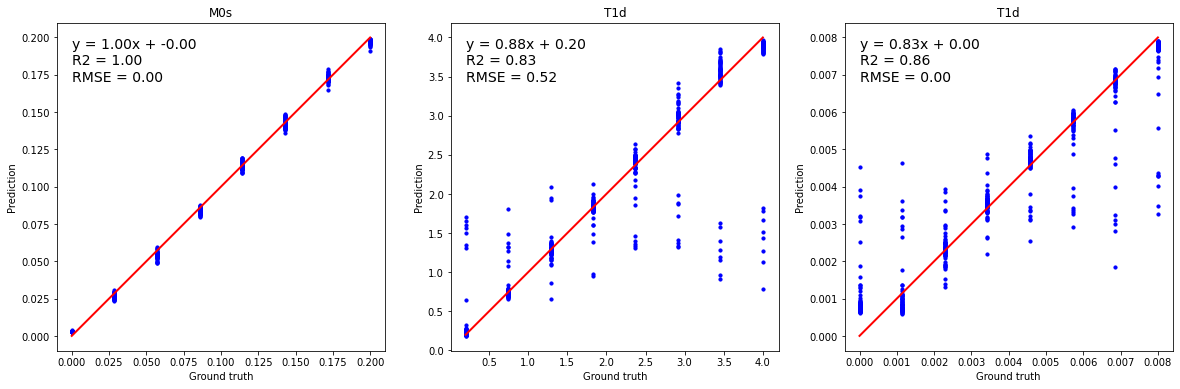

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Test network performance
print('Testing network...')
test_pred, noisy_test_pred = test()

# Scale pred labels and test labels
test_pred = test_pred * max_labels 
noisy_test_pred = noisy_test_pred * max_labels 
# Scale back test labels
gt_labels = test_labels * max_labels

# Linear fit to noiseless data
r2_M0s, r2_T1d, r2_T1f = r2_score(gt_labels[:,0], test_pred[:,0]), r2_score(gt_labels[:,1], test_pred[:,1]),r2_score(gt_labels[:,2], test_pred[:,2])
rmse_M0s, rmse_T1d, rmse_T1f = np.sqrt(mean_squared_error(gt_labels[:,0], test_pred[:,0])), np.sqrt(mean_squared_error(gt_labels[:,1], test_pred[:,1])), np.sqrt(mean_squared_error(gt_labels[:,2], test_pred[:,2]))
x_M0s = np.linspace(torch.min(gt_labels[:,0]), torch.max(gt_labels[:,0]), 10)
x_T1d  = np.linspace(torch.min(gt_labels[:,1]), torch.max(gt_labels[:,1]), 10)
x_T1f = np.linspace(torch.min(gt_labels[:,2]), torch.max(gt_labels[:,2]), 10)

m_M0s, b_M0s = np.polyfit(gt_labels[:,0], test_pred[:,0], 1)
fit_M0s = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(m_M0s, b_M0s, r2_M0s, rmse_M0s)

m_T1d, b_T1d = np.polyfit(gt_labels[:,1], test_pred[:,1], 1)
fit_T1d = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(m_T1d, b_T1d, r2_T1d, rmse_T1d)

m_T1f, b_T1f = np.polyfit(gt_labels[:,2], test_pred[:,2], 1)
fit_T1f = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(m_T1f, b_T1f, r2_T1f, rmse_T1f)

y_M0s, y_T1d, y_T1f = m_M0s * x_M0s + b_M0s, m_T1d * x_T1d + b_T1d, m_T1f * x_T1f + b_T1f

# Linear fit to noisy data
noisy_r2_M0s, noisy_r2_T1d, noisy_r2_T1f = r2_score(gt_labels[:,0], noisy_test_pred[:,0]), r2_score(gt_labels[:,1], noisy_test_pred[:,1]), r2_score(gt_labels[:,2], noisy_test_pred[:,2])
noisy_rmse_M0s, noisy_rmse_T1d, noisy_rmse_T1f = np.sqrt(mean_squared_error(gt_labels[:,0], noisy_test_pred[:,0])), np.sqrt(mean_squared_error(gt_labels[:,1], noisy_test_pred[:,1])), np.sqrt(mean_squared_error(gt_labels[:,2], noisy_test_pred[:,2]))
noisy_x_M0s = np.linspace(torch.min(gt_labels[:,0]), torch.max(gt_labels[:,0]), 10)
noisy_x_T1d = np.linspace(torch.min(gt_labels[:,1]), torch.max(gt_labels[:,1]), 10)
noisy_x_T1f = np.linspace(torch.min(gt_labels[:,2]), torch.max(gt_labels[:,2]), 10)

noisy_m_M0s, noisy_b_M0s = np.polyfit(gt_labels[:,0], noisy_test_pred[:,0], 1)
noisy_fit_M0s = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(noisy_m_M0s, noisy_b_M0s, noisy_r2_M0s, noisy_rmse_M0s)

noisy_m_T1d, noisy_b_T1d = np.polyfit(gt_labels[:,1], noisy_test_pred[:,1], 1)
noisy_fit_T1d = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(noisy_m_T1d, noisy_b_T1d, noisy_r2_T1d, noisy_rmse_T1d)

noisy_m_T1f, noisy_b_T1f = np.polyfit(gt_labels[:,2], noisy_test_pred[:,2], 1)
noisy_fit_T1f = 'y = {:.2f}x + {:.2f}\nR2 = {:.2f}\nRMSE = {:.2f}'.format(noisy_m_T1f, noisy_b_T1f, noisy_r2_T1f, noisy_rmse_T1f)

noisy_y_M0s, noisy_y_T1d, noisy_y_T1f = noisy_m_M0s * noisy_x_M0s + noisy_b_M0s, noisy_m_T1d * noisy_x_T1d + noisy_b_T1d, noisy_m_T1f * noisy_x_T1f + noisy_b_T1f
print(x_M0s)
fig2 = plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.scatter(gt_labels[:,0], test_pred[:,0], color='b', s=10)
plt.plot([min(gt_labels[:,0]), max(gt_labels[:,0])], [min(gt_labels[:,0]), max(gt_labels[:,0])],color='r', linewidth=2)
#plt.plot(x_M0s, y_M0s, color='r', linewidth=2)
#plt.plot()
plt.title('M0s')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
#plt.xlim([0, 2500])
#plt.ylim([0, 2500])
plt.text(min(gt_labels[:,0]), max(gt_labels[:,0]), fit_M0s, fontsize=14, verticalalignment='top')

plt.subplot(132)
plt.scatter(gt_labels[:,1], test_pred[:,1], color='b', s=10)
#plt.plot(x_T1d, y_T1d, color='r', linewidth=2)
plt.plot([min(gt_labels[:,1]), max(gt_labels[:,1])], [min(gt_labels[:,1]), max(gt_labels[:,1])],color='r', linewidth=2)
plt.title('T1d')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
#plt.xlim([0, 2500])
#plt.ylim([0, 2500])
plt.text(min(gt_labels[:,1]), max(gt_labels[:,1]), fit_T1d, fontsize=14, verticalalignment='top')

plt.subplot(133)
plt.scatter(gt_labels[:,2], test_pred[:,2], color='b', s=10)
#plt.plot(x_T1f, y_T1f, color='r', linewidth=2)
plt.plot([min(gt_labels[:,2]), max(gt_labels[:,2])], [min(gt_labels[:,2]), max(gt_labels[:,2])],color='r', linewidth=2)
plt.title('T1f')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
#plt.xlim([0, 2500])
#plt.ylim([0, 2500])
plt.text(min(gt_labels[:,2]), max(gt_labels[:,2]), fit_T1f, fontsize=14, verticalalignment='top')
plt.show()
fig2.savefig(directory + 'results_MT_dict_one_test.png')

#--
fig3 = plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.scatter(gt_labels[:,0], noisy_test_pred[:,0], color='b', s=10)
#plt.plot(noisy_x_M0s, noisy_y_M0s, color='r', linewidth=2)
plt.plot([min(gt_labels[:,0]), max(gt_labels[:,0])], [min(gt_labels[:,0]), max(gt_labels[:,0])],color='r', linewidth=2)
plt.title('M0s')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
#plt.xlim([0, 2500])
#plt.ylim([0, 2500])
plt.text(min(gt_labels[:,0]), max(gt_labels[:,0]), noisy_fit_M0s, fontsize=14, verticalalignment='top')

plt.subplot(132)
plt.scatter(gt_labels[:,1], noisy_test_pred[:,1], color='b', s=10)
plt.plot([min(gt_labels[:,1]), max(gt_labels[:,1])], [min(gt_labels[:,1]), max(gt_labels[:,1])],color='r', linewidth=2)
#plt.plot(noisy_x_T1d, noisy_y_T1d, color='r', linewidth=2)
plt.title('T1d')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
#plt.xlim([0, 2500])
#plt.ylim([0, 2500])
plt.text(min(gt_labels[:,1]), max(gt_labels[:,1]), noisy_fit_T1d, fontsize=14, verticalalignment='top')

plt.subplot(133)
plt.scatter(gt_labels[:,2], noisy_test_pred[:,2], color='b', s=10)
plt.plot([min(gt_labels[:,2]), max(gt_labels[:,2])], [min(gt_labels[:,2]), max(gt_labels[:,2])],color='r', linewidth=2)
#plt.plot(noisy_x_T1f, noisy_y_T1f, color='r', linewidth=2)
plt.title('T1d')
plt.axis('square')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
#plt.xlim([0, 2500])
#plt.ylim([0, 2500])
plt.text(min(gt_labels[:,2]), max(gt_labels[:,2]), noisy_fit_T1f, fontsize=14, verticalalignment='top')
plt.show()
fig3.savefig(directory + 'results_noisy_MT_dict_one_test_pres.png')
